In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
sys.path.append('../')
sys.path.append('../util/')
import feedforward_robust as ffr
import ipdb
from util import *

#Read the counter
ctr_file = "counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Setup - Dataset stuff
dataset, input_shape, num_classes = get_dataset()
x_train_flat, y_train = dataset[0] 
x_test_flat, y_test = dataset[1] 
hidden_sizes = [32,32,32,32,32,32,32]

In [4]:
x_train_flat.shape

(60000, 784)

In [5]:
def plot_singular_values(matrix, idx):
    _, sig, V = np.linalg.svd(matrix)
    plt.plot(range(len(sig)), sig, label = "Layer number %d" %idx)
    plt.legend(loc = 'upper right')
    return sig

In [6]:
def regular_training(config_inp):
    eps_train = config_inp['eps_train'] 
    eps_test = config_inp['eps_test'] 
    tensorboard_dir = config_inp['tensorboard_dir'] 
    weights_dir = config_inp['weights_dir']
    load_counter = config_inp['load_counter'] 
    sigma = config_inp['sigma']
    scope_name = config_inp['scope_name']
    
    with tf.variable_scope(scope_name) as scope:
        sess = tf.Session()
        logdir = tensorboard_dir + str(counter) + "/non_robust"

        #Create, train and test model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma =sigma)
        logger.info("Created model successfully. Now going to load weights")

        #Restore weights
        weights = tf.trainable_variables()
        saver = tf.train.Saver(weights)
        weights_path = saver.restore(sess, weights_dir + "model_" + str(load_counter) + ".ckpt")

        writer.add_graph(sess.graph)

        loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
        logger.info("----Regular test accuracy and loss ----")
        logger.info((loss_reg, acc_reg))


        with tf.variable_scope("testing_benign") as scope:
            loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
            logger.info("----Regular test accuracy and loss ----")
            logger.info((loss_reg, acc_reg))


        with tf.variable_scope("testing_adversarial") as scope:
            loss_fgsm, acc_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
            logger.info("----FGSM test accuracy and loss ----")
            logger.info((loss_fgsm, acc_fgsm))
            x_test_flat_adv = model.fgsm_np(sess, x_test_flat, y_test, eps_test)
    return model, sess

In [7]:
def adversarial_training(config):
    eps_train = config['eps_train'] 
    eps_test = config['eps_test'] 
    tensorboard_dir = config['tensorboard_dir'] 
    weights_dir = config['weights_dir']
    load_counter = config['load_counter'] 
    sigma = config['sigma']
    scope_name_rob = config['scope_name']
    sess = tf.Session()
    hidden_sizes = [32,32,32,32,32,32,32]
    
    dataset = ((x_train_flat, y_train), (x_test_flat, y_test))

    with tf.variable_scope(scope_name_rob, reuse = False) as scope:
        logdir = tensorboard_dir + str(counter) + "/robust"
        writer_robust = tf.summary.FileWriter(logdir)
        logger.info("Adversarial Training")
        robust_model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer_robust, scope = scope_name_rob, logger = logger, sigma = sigma)
        sess.run(tf.global_variables_initializer())
        robust_model.adv_fit(sess, x_train_flat, y_train, eps_train, lr = 3e-4, training_epochs = 20)

        print(robust_model.evaluate(sess, x_test_flat, y_test))
        print(robust_model.adv_evaluate(sess, x_test_flat, y_test, eps_test))
    return robust_model, sess

In [8]:
def activation_distance(activation_list):
    diff = []
    diff_norms = []
    for i in range(len(activation_list) - 1):
        difference = activation_list[i+1] - activation_list[i]
        diff.append(difference)
        diff_norms.append(np.linalg.norm(difference)/np.linalg.norm(activation_list[i]))
    return diff, diff_norms

## Regular Training

In [9]:
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"

config['load_counter'] = 58
config['sigma'] = tf.nn.relu

config['scope_name'] = "model_non_robust"

In [10]:
config['scope_name']

'model_non_robust'

In [11]:
model_non_robust, sess_non_robust = regular_training(config)

Initialized instance variables of the robust model class
I0827 00:03:54.844058 4441228736 feedforward_robust.py:30] Initialized instance variables of the robust model class
W0827 00:03:54.845580 4441228736 deprecation_wrapper.py:119] From ../feedforward_robust.py:34: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0827 00:03:54.849211 4441228736 feedforward_robust.py:36] Created placeholders for x and y
W0827 00:03:54.850768 4441228736 deprecation_wrapper.py:119] From ../util.py:31: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0827 00:03:54.851712 4441228736 deprecation_wrapper.py:119] From ../util.py:31: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0827 00:03:54.853061 4441228736 deprecation_wrapper.py:119] From ../util.py:33: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0827 00:03:54.866

In [12]:
with tf.variable_scope(config['scope_name']) as scope:
    weights_non_robust = model_non_robust.get_weights_np(sess_non_robust)

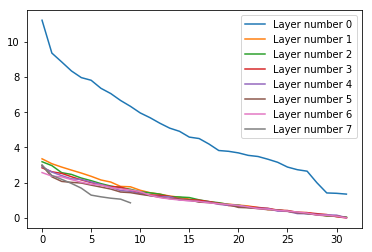

In [13]:
#Original without regularization
sing_vals = []
for (idx, weight_matrix) in enumerate(weights_non_robust):
        sig = plot_singular_values(weight_matrix, idx)
        sing_vals.append(sig)

In [14]:
sing_vals

[array([11.219591 ,  9.356054 ,  8.853931 ,  8.339419 ,  7.9637704,
         7.8134637,  7.3564215,  7.058405 ,  6.66576  ,  6.3353806,
         5.959866 ,  5.688879 ,  5.37518  ,  5.0967546,  4.916018 ,
         4.587053 ,  4.5058117,  4.1946373,  3.826147 ,  3.7809627,
         3.6920755,  3.5512054,  3.4865568,  3.3326955,  3.158114 ,
         2.8874547,  2.7380967,  2.6529348,  1.9937172,  1.4182587,
         1.3975704,  1.3518547], dtype=float32),
 array([3.3555133 , 3.0770993 , 2.8867211 , 2.7135534 , 2.546874  ,
        2.3628848 , 2.154325  , 2.0367765 , 1.7889944 , 1.7673813 ,
        1.5701079 , 1.4319557 , 1.3497653 , 1.2428688 , 1.1750933 ,
        1.0686702 , 0.9814576 , 0.8870417 , 0.8434903 , 0.7797669 ,
        0.7305877 , 0.6794515 , 0.58738804, 0.4739951 , 0.4635789 ,
        0.3811394 , 0.31063223, 0.3000163 , 0.18293275, 0.12966576,
        0.1047547 , 0.02554336], dtype=float32),
 array([3.190353  , 2.9698312 , 2.5693169 , 2.4689467 , 2.2635596 ,
        2.1147387 

In [15]:
#Regular points
acts = model_non_robust.get_activation(sess_non_robust, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = model_non_robust.fgsm_np(sess_non_robust, x_test_flat, y_test, config['eps_test'])
acts_adv = model_non_robust.get_activation(sess_non_robust, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [16]:
diff_norm

[1.2468842, 1.2277437, 1.3311783, 1.2483853, 1.2214985, 1.3134739]

In [17]:
diff_norm_adv

[1.239904, 1.1469193, 1.2457478, 1.247082, 1.2253306, 1.321806]

In [18]:
dphi_dx_test = model_non_robust.get_dphi_dx(sess_non_robust, x_test_flat)[0]

> /Users/adhyyan/projects/robustNN/feedforward_robust.py(119)get_dphi_dx()
    118         ipdb.set_trace()
--> 119         dphi_dx = tf.gradients(self.featurizations, self.x)
    120         feed_dict = {self.x: x_train}

ipdb> c


In [19]:
dphi_dx_test[0]

array([-6.83652610e-02, -3.22156362e-02,  2.46529318e-02, -1.08392298e-01,
       -2.07012251e-01,  1.57032326e-01,  1.58749342e-01, -2.90332794e-01,
        2.02615231e-01, -3.33121061e-01, -1.24298474e-02, -2.66678501e-02,
        2.10098654e-01, -1.85666263e-01, -2.72382796e-02,  5.24365269e-02,
       -1.39815763e-01,  2.34737042e-02, -1.45724714e-01, -2.89138723e-02,
       -3.17042381e-01,  3.63251679e-02,  1.34408414e-01, -1.70230478e-01,
        5.40733747e-02, -2.61806399e-01, -2.59789467e-01, -9.35012177e-02,
        4.60812151e-02, -1.41342342e-01, -2.61996239e-02, -1.16768956e-01,
        3.18005711e-01, -7.04690218e-01, -1.13004541e+00, -1.08753252e+00,
       -1.16294587e+00, -6.61593020e-01, -4.91458744e-01,  1.59711480e-01,
       -3.10366064e-01, -3.18839133e-01,  1.78596914e-01, -8.27888548e-02,
       -7.35210001e-01, -8.23494017e-01, -4.68693763e-01, -3.21548045e-01,
       -8.32149923e-01, -4.73565131e-01, -6.93169117e-01, -2.04907715e-01,
       -2.18575910e-01,  

In [20]:
dphi_dx_test_non_robust = dphi_dx_test

In [21]:
np.mean(np.abs(dphi_dx_test_non_robust))

0.90502423

## Trace regularization for first layer

In [22]:
#Config
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"

config['load_counter'] = 121
config['sigma'] = tf.nn.relu

config['scope_name'] = "model_non_robust"

In [23]:
config['scope_name']

'model_non_robust'

In [24]:
reg_model, sess_reg = regular_training(config)

Initialized instance variables of the robust model class
I0827 00:05:04.731079 4441228736 feedforward_robust.py:30] Initialized instance variables of the robust model class
Created placeholders for x and y
I0827 00:05:04.734788 4441228736 feedforward_robust.py:36] Created placeholders for x and y
Created layers and tensor for logits
I0827 00:05:04.779482 4441228736 feedforward_robust.py:40] Created layers and tensor for logits
Added loss computation to the graph
I0827 00:05:04.808171 4441228736 feedforward_robust.py:45] Added loss computation to the graph
Added accuracy computation to the graph
I0827 00:05:04.820952 4441228736 feedforward_robust.py:49] Added accuracy computation to the graph
Model graph was created
I0827 00:05:04.825824 4441228736 feedforward_robust.py:52] Model graph was created
Created model successfully. Now going to load weights
I0827 00:05:04.830152 4441228736 <ipython-input-6-9a6c637c42f4>:17] Created model successfully. Now going to load weights
Model was evalua

In [25]:
with tf.variable_scope(config['scope_name']) as scope:
    weights = reg_model.get_weights_np(sess_reg)

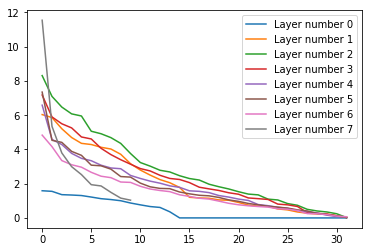

In [26]:
#With regularization
sing_vals_reg = []
for (idx, weight_matrix) in enumerate(weights):
        sig = plot_singular_values(weight_matrix, idx)
        sing_vals_reg.append(sig)

**Interpretation** This is pretty interesting. When you penalize the singular values of the first layer, all the other layers start increasing to compensate - I'm guessing to keep the expressiveness high. Probably, if we penalize all the singular values, it may not learn anything?

So we still have not suceeded at replicating the singular value spectrum of the robust model - so it is difficult to conclude whether the singular value spectrum is a determinant of adversarial robustness or not

In [27]:
#With regularization - first layer
sing_vals_reg

[array([1.5870155e+00, 1.5522803e+00, 1.3584403e+00, 1.3370733e+00,
        1.3070780e+00, 1.2188531e+00, 1.1234620e+00, 1.0728732e+00,
        1.0041257e+00, 8.7067133e-01, 7.6290888e-01, 6.6413921e-01,
        6.1234343e-01, 3.5728675e-01, 6.2625506e-04, 4.9098406e-04,
        4.8556362e-04, 4.5167084e-04, 3.1356234e-04, 3.0216103e-04,
        2.7841594e-04, 2.0602574e-04, 1.9646439e-04, 1.8619838e-04,
        1.4287693e-04, 1.3560396e-04, 1.2213681e-04, 3.9542541e-05,
        3.5572761e-05, 1.7289583e-05, 8.5304418e-06, 5.9684144e-06],
       dtype=float32),
 array([6.035554  , 5.8620715 , 5.20899   , 4.6957164 , 4.3550816 ,
        4.287016  , 4.125534  , 4.0239434 , 3.7177262 , 3.1656983 ,
        2.7954736 , 2.499863  , 2.23836   , 2.055546  , 1.7796141 ,
        1.2052387 , 1.1660684 , 1.1480169 , 1.0525272 , 1.0315014 ,
        0.90306103, 0.74932116, 0.6895752 , 0.6741662 , 0.5238548 ,
        0.469349  , 0.34676093, 0.27730793, 0.22861174, 0.21915486,
        0.12821923, 0.04

In [28]:
#Regular points
acts = reg_model.get_activation(sess_reg, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = reg_model.fgsm_np(sess_reg, x_test_flat, y_test, config['eps_test'])
acts_adv = reg_model.get_activation(sess_reg, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [29]:
diff_norm

[1.6056864, 1.8563683, 1.5560254, 1.3894248, 1.1853814, 1.2059872]

In [30]:
diff_norm_adv

[1.5158699, 1.7118087, 1.3908907, 1.3478867, 1.1872182, 1.2078623]

In [31]:
dphi_dx_robust_first_reg = reg_model.get_dphi_dx(sess_reg, x_test_flat)
np.mean(np.abs(dphi_dx_robust_first_reg))

> /Users/adhyyan/projects/robustNN/feedforward_robust.py(119)get_dphi_dx()
    118         ipdb.set_trace()
--> 119         dphi_dx = tf.gradients(self.featurizations, self.x)
    120         feed_dict = {self.x: x_train}

ipdb> c


0.29407898

# Trace regularization for all layers

In [32]:
#Config
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"
config['load_counter'] = 126
config['sigma'] = tf.nn.relu
config['scope_name'] = "model_non_robust"

In [33]:
model_all_reg, sess_all_reg = regular_training(config)

Initialized instance variables of the robust model class
I0827 00:05:13.779057 4441228736 feedforward_robust.py:30] Initialized instance variables of the robust model class
Created placeholders for x and y
I0827 00:05:13.781883 4441228736 feedforward_robust.py:36] Created placeholders for x and y
Created layers and tensor for logits
I0827 00:05:13.819461 4441228736 feedforward_robust.py:40] Created layers and tensor for logits
Added loss computation to the graph
I0827 00:05:13.847269 4441228736 feedforward_robust.py:45] Added loss computation to the graph
Added accuracy computation to the graph
I0827 00:05:13.854665 4441228736 feedforward_robust.py:49] Added accuracy computation to the graph
Model graph was created
I0827 00:05:13.860491 4441228736 feedforward_robust.py:52] Model graph was created
Created model successfully. Now going to load weights
I0827 00:05:13.867136 4441228736 <ipython-input-6-9a6c637c42f4>:17] Created model successfully. Now going to load weights
Model was evalua

In [34]:
with tf.variable_scope(config['scope_name']) as scope:
    weights = model_all_reg.get_weights_np(sess_all_reg)

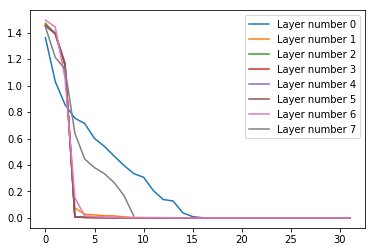

In [35]:
#With regularization
sing_vals_all = []
for (idx, weight_matrix) in enumerate(weights):
        sig = plot_singular_values(weight_matrix, idx)
        sing_vals_all.append(sig)

In [36]:
#Regular points
acts = model_all_reg.get_activation(sess_all_reg, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = model_all_reg.fgsm_np(sess_all_reg, x_test_flat, y_test, config['eps_test'])
acts_adv = model_all_reg.get_activation(sess_all_reg, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [37]:
diff_norm

[1.2381881, 1.1723968, 0.9998556, 1.2088721, 1.156904, 1.2247998]

In [38]:
diff_norm_adv

[1.2208154, 1.1831144, 1.000097, 1.2062595, 1.1468935, 1.2146919]

In [64]:
dphi_dx_robust_all_reg = reg_model.get_dphi_dx(sess_all_reg, x_test_flat)
np.mean(np.abs(dphi_dx_robust_all_reg))

0.20034555

# FGSM Adversarial Training

In [39]:
#Config
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"
config['load_counter'] = 75
config['sigma'] = tf.nn.relu
config['scope_name'] = "model_robust"

In [40]:
model_rob, sess_rob = adversarial_training(config)

Adversarial Training
I0827 00:05:15.459180 4441228736 <ipython-input-7-8fee2187f6d8>:17] Adversarial Training
Initialized instance variables of the robust model class
I0827 00:05:15.460362 4441228736 feedforward_robust.py:30] Initialized instance variables of the robust model class
Created placeholders for x and y
I0827 00:05:15.463865 4441228736 feedforward_robust.py:36] Created placeholders for x and y
Created layers and tensor for logits
I0827 00:05:15.594460 4441228736 feedforward_robust.py:40] Created layers and tensor for logits
Added loss computation to the graph
I0827 00:05:15.618711 4441228736 feedforward_robust.py:45] Added loss computation to the graph
Added accuracy computation to the graph
I0827 00:05:15.627650 4441228736 feedforward_robust.py:49] Added accuracy computation to the graph
Model graph was created
I0827 00:05:15.630514 4441228736 feedforward_robust.py:52] Model graph was created
W0827 00:05:15.864074 4441228736 deprecation.py:323] From ../feedforward_robust.py

(0.36354923, 0.8883)


Model is being evaluated on FGSM data
I0827 00:06:29.725168 4441228736 feedforward_robust.py:291] Model is being evaluated on FGSM data


(0.48591465, 0.8428)


In [41]:
with tf.variable_scope(config['scope_name']) as scope:
    weights_robust = model_rob.get_weights_np(sess_rob)

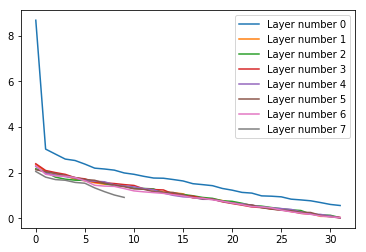

In [42]:
sing_vals_robust = []
for (idx, weight_matrix) in enumerate(weights_robust):
    sig = plot_singular_values(weight_matrix, idx)
    sing_vals_robust.append(sig)

In [43]:
dphi_dx_robust = model_rob.get_dphi_dx(sess_rob, x_test_flat)
np.mean(np.abs(dphi_dx_robust))

0.35163555

In [44]:
np.mean(np.abs(dphi_dx_robust))

0.35163555

In [45]:
sing_vals[0]

array([11.219591 ,  9.356054 ,  8.853931 ,  8.339419 ,  7.9637704,
        7.8134637,  7.3564215,  7.058405 ,  6.66576  ,  6.3353806,
        5.959866 ,  5.688879 ,  5.37518  ,  5.0967546,  4.916018 ,
        4.587053 ,  4.5058117,  4.1946373,  3.826147 ,  3.7809627,
        3.6920755,  3.5512054,  3.4865568,  3.3326955,  3.158114 ,
        2.8874547,  2.7380967,  2.6529348,  1.9937172,  1.4182587,
        1.3975704,  1.3518547], dtype=float32)

In [46]:
sing_vals_robust[0]

array([8.668042  , 3.0275862 , 2.8086052 , 2.591504  , 2.528774  ,
       2.3710003 , 2.193908  , 2.1565828 , 2.1069272 , 1.9845219 ,
       1.9248238 , 1.8359823 , 1.7615126 , 1.7524536 , 1.6958052 ,
       1.633525  , 1.5141041 , 1.472503  , 1.4269382 , 1.3054806 ,
       1.2304821 , 1.1330246 , 1.1021879 , 0.9809109 , 0.9663262 ,
       0.9386956 , 0.83700716, 0.8038633 , 0.765353  , 0.6886189 ,
       0.6059937 , 0.5588499 ], dtype=float32)

In [47]:
sing_vals[1]

array([3.3555133 , 3.0770993 , 2.8867211 , 2.7135534 , 2.546874  ,
       2.3628848 , 2.154325  , 2.0367765 , 1.7889944 , 1.7673813 ,
       1.5701079 , 1.4319557 , 1.3497653 , 1.2428688 , 1.1750933 ,
       1.0686702 , 0.9814576 , 0.8870417 , 0.8434903 , 0.7797669 ,
       0.7305877 , 0.6794515 , 0.58738804, 0.4739951 , 0.4635789 ,
       0.3811394 , 0.31063223, 0.3000163 , 0.18293275, 0.12966576,
       0.1047547 , 0.02554336], dtype=float32)

In [48]:
sing_vals_robust[1]

array([2.3472326 , 2.0571952 , 1.9458408 , 1.862193  , 1.7087817 ,
       1.6441474 , 1.5533618 , 1.4898914 , 1.4631817 , 1.4248537 ,
       1.3121846 , 1.2884251 , 1.2365174 , 1.1529156 , 1.1183392 ,
       1.0714715 , 0.89178085, 0.8623658 , 0.8474619 , 0.77623355,
       0.675907  , 0.63338405, 0.56522477, 0.5040487 , 0.40393373,
       0.3867541 , 0.29364678, 0.2484564 , 0.20550714, 0.08429361,
       0.08139554, 0.0232873 ], dtype=float32)

In [49]:
sing_vals[2]

array([3.190353  , 2.9698312 , 2.5693169 , 2.4689467 , 2.2635596 ,
       2.1147387 , 1.9464352 , 1.807925  , 1.7158626 , 1.6282052 ,
       1.4895344 , 1.4230894 , 1.3509948 , 1.2100762 , 1.1883975 ,
       1.1575755 , 1.0261064 , 0.9290708 , 0.86253023, 0.76148295,
       0.72430235, 0.61824846, 0.55077726, 0.5103169 , 0.43055552,
       0.38944536, 0.3188387 , 0.23886074, 0.20708954, 0.12144791,
       0.08276477, 0.04309303], dtype=float32)

In [50]:
sing_vals_robust[2]

array([2.1672957 , 2.0180643 , 1.8007178 , 1.7116151 , 1.6684567 ,
       1.6588888 , 1.6079856 , 1.5218521 , 1.4283036 , 1.4044054 ,
       1.3130867 , 1.305847  , 1.2863029 , 1.1093911 , 1.0630447 ,
       1.044357  , 0.98543143, 0.91216093, 0.87283087, 0.7662327 ,
       0.7415061 , 0.65783364, 0.5574702 , 0.5313077 , 0.47061208,
       0.4197575 , 0.3697994 , 0.340038  , 0.18279463, 0.14635234,
       0.13183431, 0.0268627 ], dtype=float32)

In [51]:
sing_vals[-1]

array([3.005259 , 2.409253 , 2.191596 , 1.9573574, 1.6897454, 1.2956517,
       1.1981667, 1.1196339, 1.0656364, 0.8578519], dtype=float32)

In [52]:
sing_vals_robust[-1]

array([2.0482244, 1.8006438, 1.6942627, 1.6641313, 1.5699601, 1.5340655,
       1.3297445, 1.1649275, 1.0186068, 0.913769 ], dtype=float32)

In [53]:
#Regular points
acts = model_rob.get_activation(sess_rob, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = model_rob.fgsm_np(sess_rob, x_test_flat, y_test, config['eps_test'])
acts_adv = model_rob.get_activation(sess_rob, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [54]:
diff_norm

[1.0691103, 1.0876144, 1.1016235, 1.0759735, 1.1082327, 1.1500996]

In [55]:
diff_norm_adv

[1.0110456, 1.0374327, 1.0829256, 1.0939339, 1.0789808, 1.1086173]

# Comparison plots

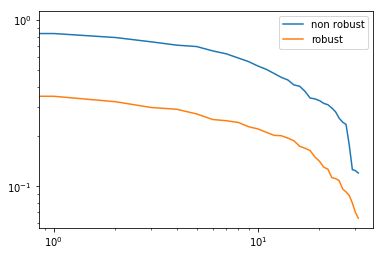

In [56]:
norm_factor_non = sing_vals[0][0]
sing_non = sing_vals[0]/norm_factor_non
norm_factor_rob = sing_vals_robust[0][0]
sing_rob = sing_vals_robust[0]/norm_factor_rob

plt.loglog(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.loglog(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

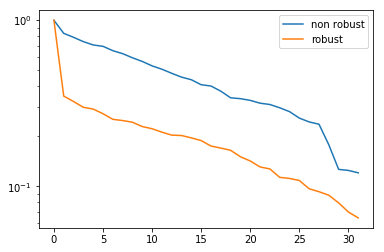

In [57]:
plt.semilogy(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.semilogy(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

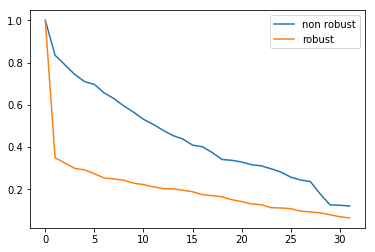

In [58]:
plt.plot(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.plot(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [59]:
def all_plots_layer_k(k):
    norm_factor_non = sing_vals[k][0]
    print("-----NORM FACTOR NON---")
    print(norm_factor_non)
    sing_non = sing_vals[k]/norm_factor_non
    norm_factor_rob = sing_vals_robust[k][0]
    print("-----NORM FACTOR ROB---")
    print(norm_factor_rob)
    sing_rob = sing_vals_robust[k]/norm_factor_rob
    plt.loglog(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.loglog(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()
    plt.semilogy(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.semilogy(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()
    plt.plot(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.plot(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()

In [60]:
num_layers = len(sing_vals)

In [61]:
num_layers

8

0
-----------
-----NORM FACTOR NON---
11.219591
-----NORM FACTOR ROB---
8.668042


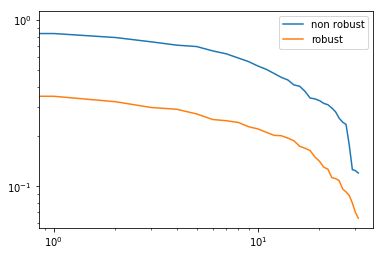

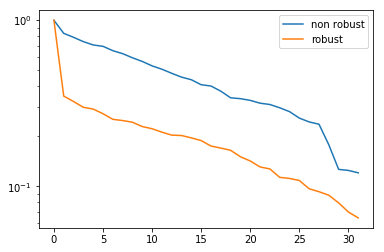

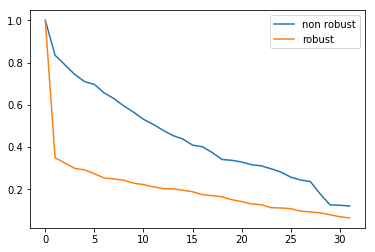

-----------
1
-----------
-----NORM FACTOR NON---
3.3555133
-----NORM FACTOR ROB---
2.3472326


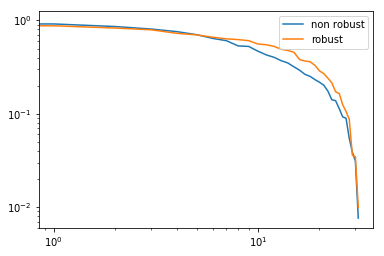

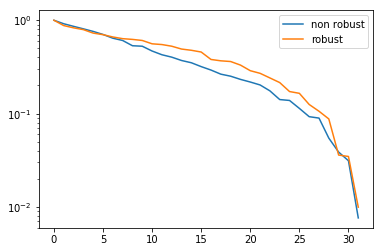

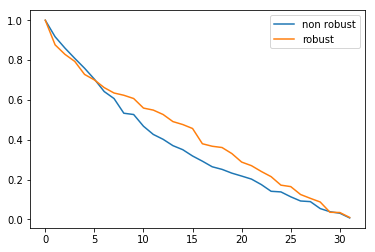

-----------
2
-----------
-----NORM FACTOR NON---
3.190353
-----NORM FACTOR ROB---
2.1672957


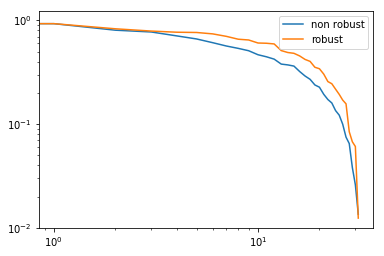

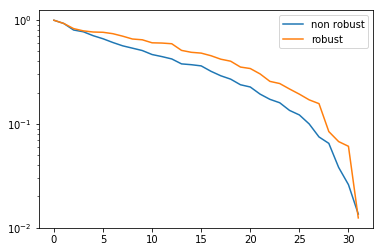

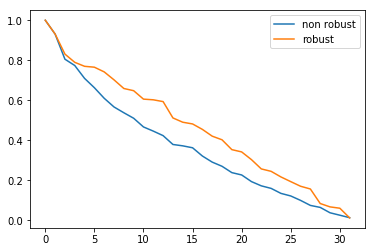

-----------
3
-----------
-----NORM FACTOR NON---
2.8452258
-----NORM FACTOR ROB---
2.3868625


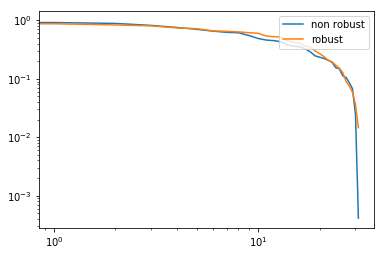

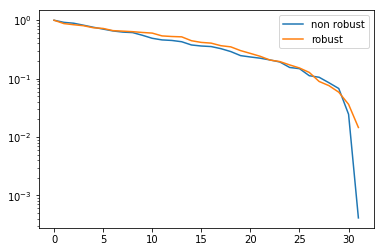

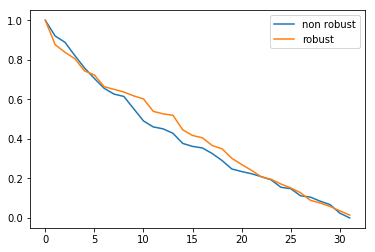

-----------
4
-----------
-----NORM FACTOR NON---
2.901472
-----NORM FACTOR ROB---
2.2696803


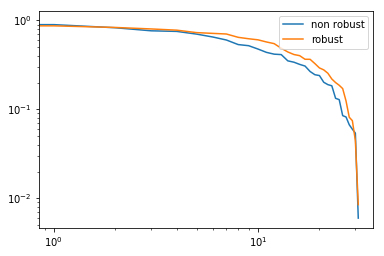

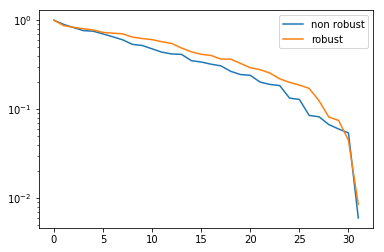

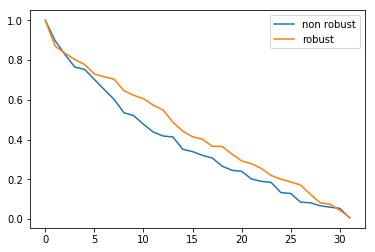

-----------
5
-----------
-----NORM FACTOR NON---
2.9760718
-----NORM FACTOR ROB---
2.1241174


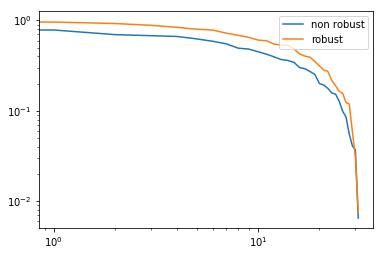

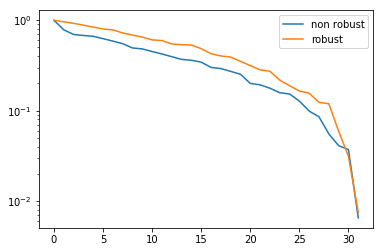

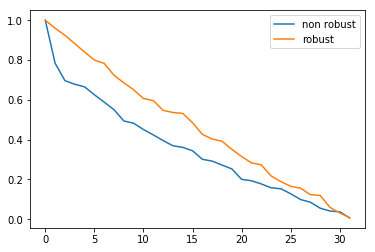

-----------
6
-----------
-----NORM FACTOR NON---
2.5741491
-----NORM FACTOR ROB---
2.2991455


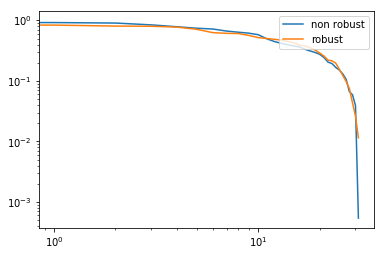

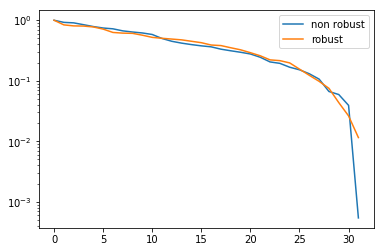

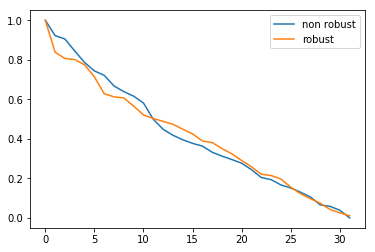

-----------
7
-----------
-----NORM FACTOR NON---
3.005259
-----NORM FACTOR ROB---
2.0482244


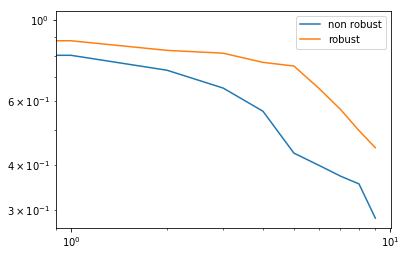

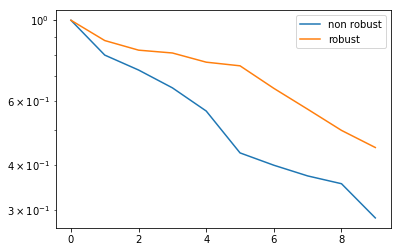

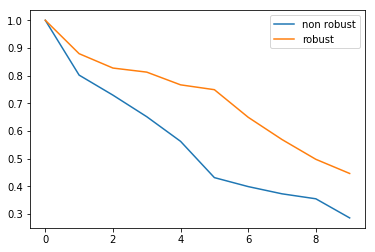

-----------


In [62]:
for k in range(8):
    print(k)
    print("-----------")
    all_plots_layer_k(k)
    print("-----------")

0
-----------
-----NORM FACTOR NON---
11.219591
-----NORM FACTOR ROB---
8.668042


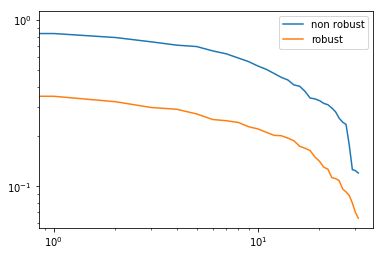

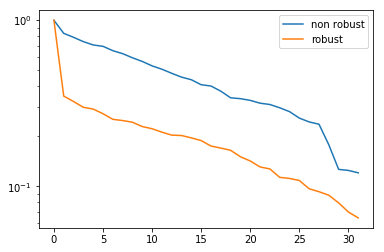

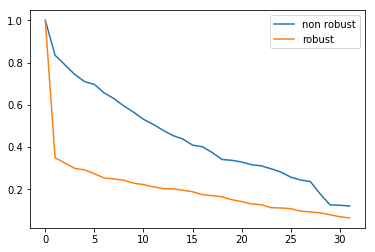

-----------
1
-----------
-----NORM FACTOR NON---
3.3555133
-----NORM FACTOR ROB---
2.3472326


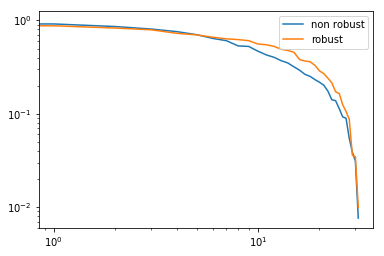

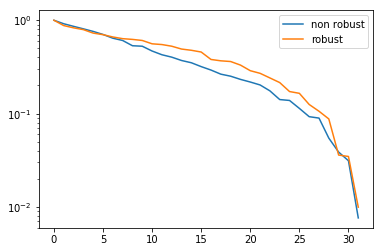

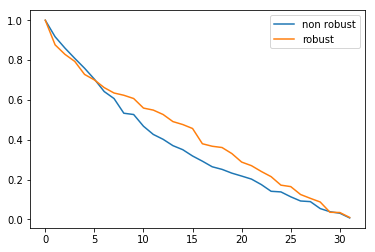

-----------
2
-----------
-----NORM FACTOR NON---
3.190353
-----NORM FACTOR ROB---
2.1672957


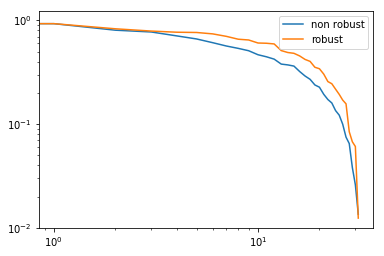

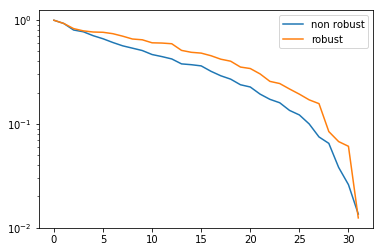

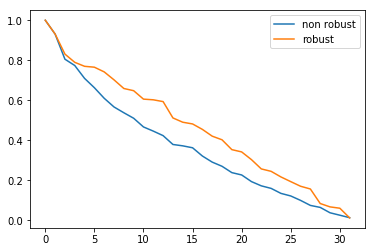

-----------
3
-----------
-----NORM FACTOR NON---
2.8452258
-----NORM FACTOR ROB---
2.3868625


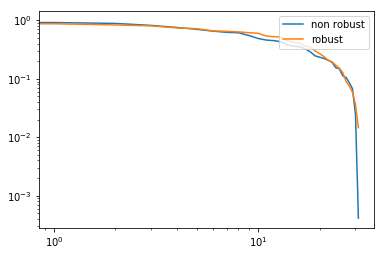

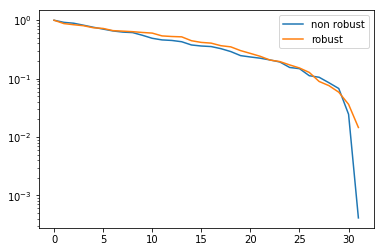

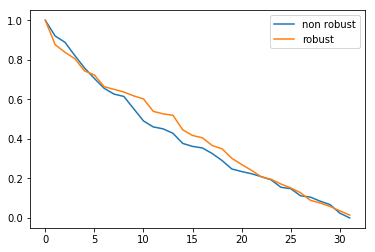

-----------
4
-----------
-----NORM FACTOR NON---
2.901472
-----NORM FACTOR ROB---
2.2696803


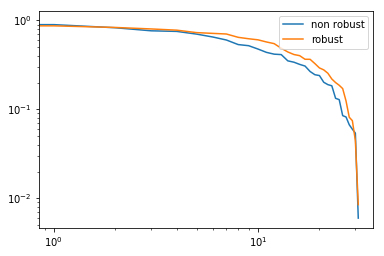

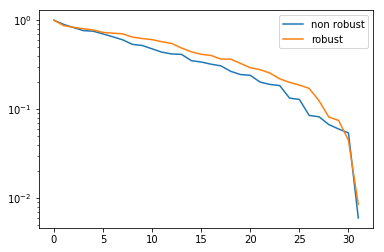

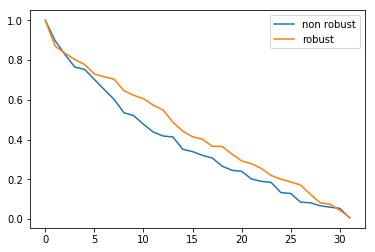

-----------
5
-----------
-----NORM FACTOR NON---
2.9760718
-----NORM FACTOR ROB---
2.1241174


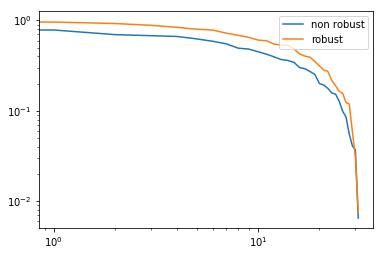

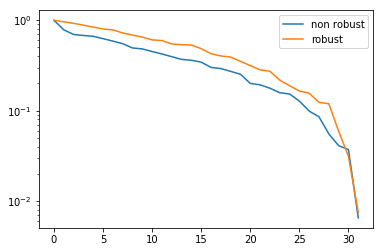

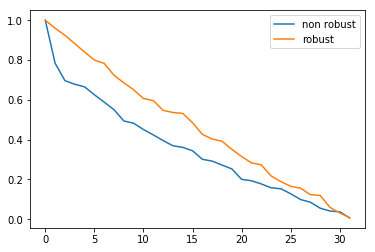

-----------
6
-----------
-----NORM FACTOR NON---
2.5741491
-----NORM FACTOR ROB---
2.2991455


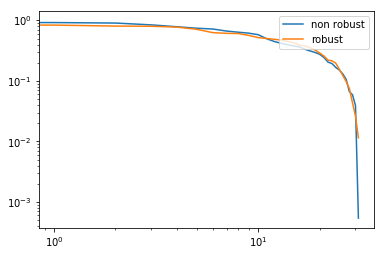

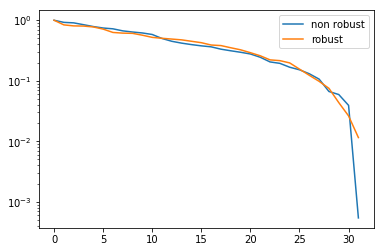

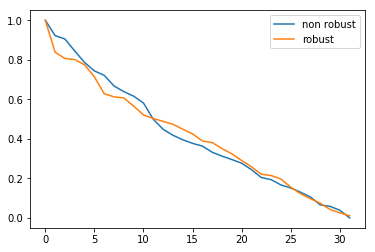

-----------
7
-----------
-----NORM FACTOR NON---
3.005259
-----NORM FACTOR ROB---
2.0482244


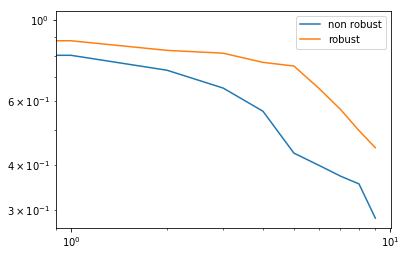

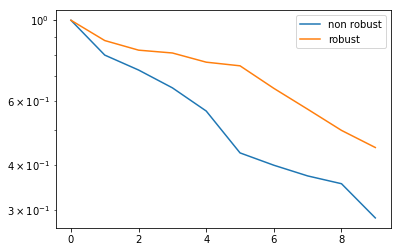

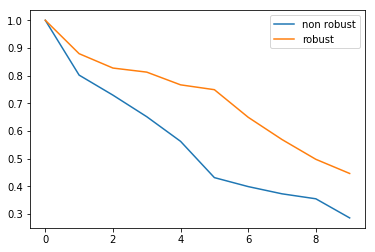

-----------


In [63]:
for k in range(8):
    print(k)
    print("-----------")
    all_plots_layer_k(k)
    print("-----------")